# Lightcurve statistics with real data 

Real data is messy.  Observational data suffers from a range of practical issues that degrade the quality of the measurements we can make and limit the precision of those measurements.  So every real-world measurement is assigned a measurement error to represent this uncertainty.  

The purpose of this notebook is to demonstrate the impact these uncertainties have on our calculations of statistics for lightcurves. 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import copy
from romerea_toolkit import crossmatch,hd5_utils 

Let's use some real-world data from the ROME survey to illustrate this.

In [2]:
# Load the crossmatch table for an example field
crossmatch_file_path = '/Users/rstreet/ROME/ROME-FIELD-01/DR1/ROME-FIELD-01_field_crossmatch.fits'
xmatch = crossmatch.CrossMatchTable()
xmatch.load(crossmatch_file_path, log=None)

In [3]:
# Load the timeseries datacube for one quadrant of this field
phot_file_path = '/Users/rstreet/ROME/ROME-FIELD-01/DR1/ROME-FIELD-01_quad1_photometry.hdf5'
phot_data = hd5_utils.read_phot_from_hd5_file(phot_file_path)

In [4]:
# Pick a random star to use as an example
istar = 6000

In [5]:
# Use the xmatch.images table's filter column to find the image indices of the datapoints for a chosen filter 
use_filter = 'rp'   # Can be 'gp', 'rp', or 'ip'

idx = np.where(xmatch.images['filter'] == use_filter)[0] 

In [6]:
# Extract the normalized lightcurve for this star, selecting columns for 
# HJD timestamp, normalized magnitude and magnitude error and qc_flag
star_lc = phot_data[istar, idx, :]
star_lc = star_lc[:, [0,7,8,16]]

In [7]:
# Measurements that were known to be of low quality during the data reduction can be filtered out like this...
jdx = np.where(star_lc[:,3] == 0.0)[0]
jdx2 = np.where(star_lc[:,2] != 0.0)[0]
valid = list(set(jdx).intersection(set(jdx2)))

Plotting this example lightcurve, we can see that even though we filtered out the data points that are flagged as "bad", the "good" datapoints still have errorbars that can vary widely from one datapoint to another.  This happens because observations made on different nights from ground-based telescopes are taken in quite different conditions.  The weather strongly impacts the quality of the measurements, as does the overall brightness of the background sky.  This changes throughout the month with the phases and movement of the Moon relative to our target.  Note that these measurements are still valid data, provided our errorbars accurately represent the measurement uncertainty introduced by these external factors.  

Text(0.5, 1.0, 'Example of ROME star lightcurve in rp')

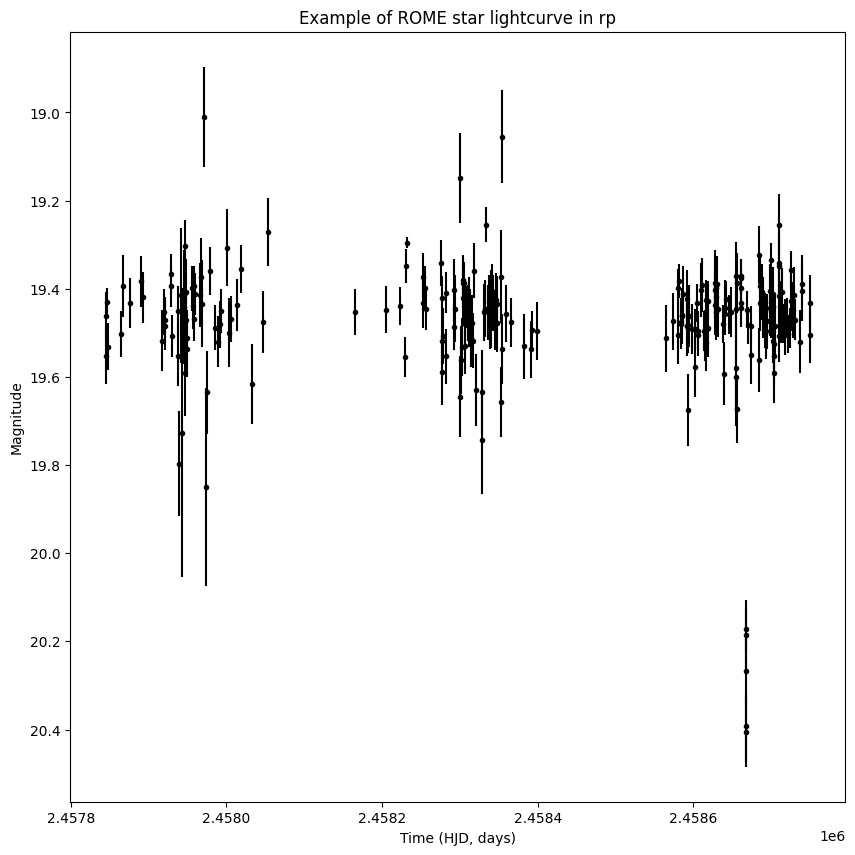

In [8]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

ax.errorbar(star_lc[valid,0], star_lc[valid,1], yerr=star_lc[valid,2], c='black', marker='.', ls='none')

[ymin, ymax] = ax.get_ylim() 
ax.set_ylim([ymax, ymin])
ax.set_xlabel('Time (HJD, days)')
ax.set_ylabel('Magnitude')
ax.set_title('Example of ROME star lightcurve in ' + use_filter)

Now let's take a look at what happens when we calculate statistics for this lightcurve.  To begin with, let's use numpy's built in methods for mean, median and standard deviation. Note that these methods don't take the measurement uncertainties into account at all. 

In [10]:
mean = star_lc[valid,1].mean()
median = np.median(star_lc[valid,1])
stddev = star_lc[valid,1].std()

print('Lightcurve mean magnitude = ' + str(round(mean,4)) + ' mag')
print('Lightcurve median magnitude = ' + str(round(median,4)) + ' mag')
print('Lightcurve standard deviation = ' + str(round(stddev,4)) + ' mag')

Lightcurve mean magnitude = 19.4754 mag
Lightcurve median magnitude = 19.453 mag
Lightcurve standard deviation = 0.1524 mag


Text(0.5, 1.0, 'Example of ROME star lightcurve in rp')

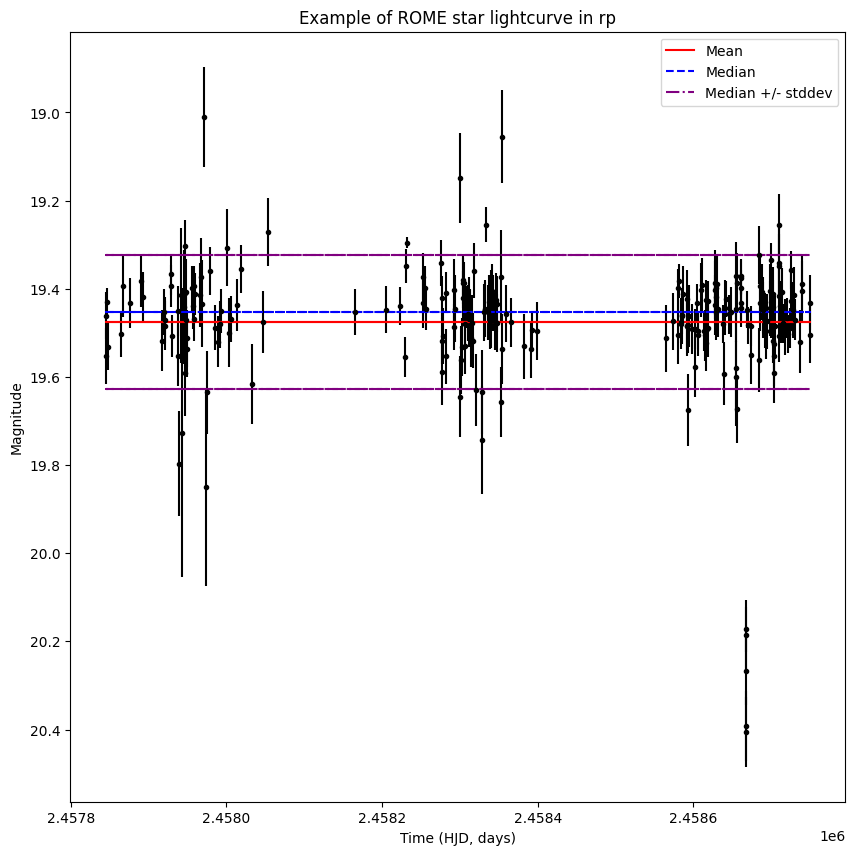

In [11]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

ax.errorbar(star_lc[valid,0], star_lc[valid,1], yerr=star_lc[valid,2], c='black', marker='.', ls='none')

ax.plot(star_lc[valid,0], [mean]*len(star_lc[valid,0]), c='red', ls='-', label='Mean')
ax.plot(star_lc[valid,0], [median]*len(star_lc[valid,0]), c='blue', ls='--', label='Median')
ax.plot(star_lc[valid,0], [mean-stddev]*len(star_lc[valid,0]), c='purple', ls='-.', label='Median +/- stddev')
ax.plot(star_lc[valid,0], [mean+stddev]*len(star_lc[valid,0]), c='purple', ls='-.')

ax.set_xlabel('Time (HJD, days)')
ax.set_ylabel('Magnitude')
[ymin, ymax] = ax.get_ylim() 
ax.set_ylim([ymax, ymin])
ax.legend()
ax.set_title('Example of ROME star lightcurve in ' + use_filter)

The mean, median and standard deviation are useful statistics but they are not always robust in cases where a lightcurve includes a number of measurements with large errorbars. 

For a Gaussian distribution of data, ~68% of points should lie within +/-1 standard deviation (or sigma) from the mean [for more information, see this article](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule).  In the above plot this means that ~68% of the black points should fall between the dash-dot purple lines.  

In practice, datapoints with large errors and high scatter (i.e. they lie a long way from the mean value) are artificially inflating the standard deviation value, because the calculation of this quantity didn't take the large errorbars into account. 

This is why it is useful to apply some more robust statistics, weight the contribution of each datapoint to a measurement by the measurement uncertainty.  

One of the most common statistics used in photometric timeseries like lightcurves is the [Root Mean Square (or RMS)](https://en.wikipedia.org/wiki/Root_mean_square), weighted by the magnitude errors. 

In [12]:
# We can calculate the RMS for a lightcurve like this...

def calc_weighted_rms(star_lc, valid):
    """
    Function to calculate the weighted mean and RMS for a single lightcurve
    """
    
    # These are the weights for each datapoint calculated from the magnitude errorbars
    err_squared_inv = 1.0 / (star_lc[valid,2]*star_lc[valid,2])  
    
    # Next, calculate the weighted mean magnitude.  Note this is also a measurement and therefore formally has an error of its own...
    wmean =  (star_lc[valid,1] * err_squared_inv).sum() / (err_squared_inv.sum())
    werror = np.sqrt( 1.0 / (err_squared_inv.sum()) )
    
    # Now calculate the weighted RMS
    dmags = star_lc[valid,1] - wmean  # These are the residuals
    rms =  np.sqrt( (dmags**2 * err_squared_inv).sum() / (err_squared_inv.sum()) )
    
    print('Lightcurve weighted mean magnitude = ' + str(round(wmean,4)) + ' +/- ' + str(round(werror,4)) + ' mag')
    print('Lightcurve RMS = ' + str(round(rms,4)) + ' mag')

    return wmean, rms

In [15]:
wmean, rms = calc_weighted_rms(star_lc, valid)

Lightcurve weighted mean magnitude = 19.4465 +/- 0.0036 mag
Lightcurve RMS = 0.1242 mag


Text(0.5, 1.0, 'Example of ROME star lightcurve in rp')

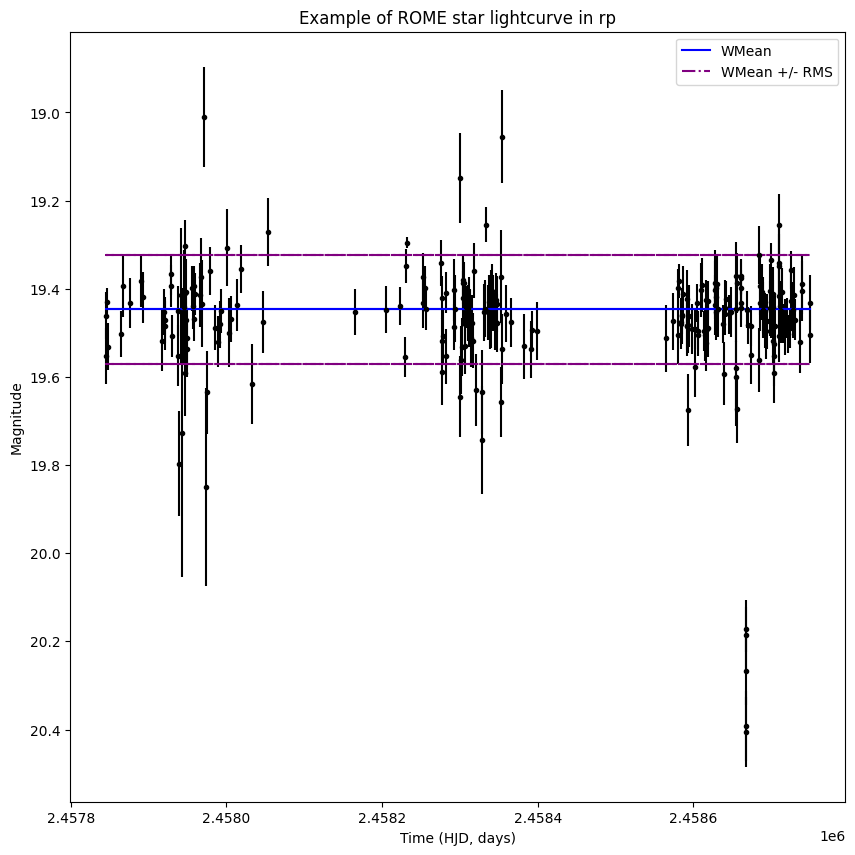

In [16]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

ax.errorbar(star_lc[valid,0], star_lc[valid,1], yerr=star_lc[valid,2], c='black', marker='.', ls='none')

ax.plot(star_lc[valid,0], [wmean]*len(star_lc[valid,0]), c='blue', ls='-', label='WMean')
ax.plot(star_lc[valid,0], [wmean-rms]*len(star_lc[valid,0]), c='purple', ls='-.', label='WMean +/- RMS')
ax.plot(star_lc[valid,0], [wmean+rms]*len(star_lc[valid,0]), c='purple', ls='-.')

ax.set_xlabel('Time (HJD, days)')
ax.set_ylabel('Magnitude')
[ymin, ymax] = ax.get_ylim() 
ax.set_ylim([ymax, ymin])
ax.legend()
ax.set_title('Example of ROME star lightcurve in ' + use_filter)

So the weighted mean and RMS can be more robust estimators of the mean magnitude and photometric scatter for a real-world lightcurve, by reducing the influence of highly scattered points with large uncertainties.  

## Separating variable from constant stars 

These statistics are also sensitive to scattered datapoints with *small* errorbars, which is a useful feature.  Let's look at a lightcurve which has some good-quality (=low error) measurements that are quite separated from the mean magnitude...

In [17]:
istar = 1000
use_filter = 'rp'   # Can be 'gp', 'rp', or 'ip'
idx = np.where(xmatch.images['filter'] == use_filter)[0] 
star_lc = phot_data[istar, idx, :]
star_lc = star_lc[:, [0,7,8,16]]
jdx = np.where(star_lc[:,3] == 0.0)[0]
jdx2 = np.where(star_lc[:,2] != 0.0)[0]
valid = list(set(jdx).intersection(set(jdx2)))

mean = star_lc[valid,1].mean()
median = np.median(star_lc[valid,1])
stddev = star_lc[valid,1].std()

print('Lightcurve mean magnitude = ' + str(round(mean,4)) + ' mag')
print('Lightcurve median magnitude = ' + str(round(median,4)) + ' mag')
print('Lightcurve standard deviation = ' + str(round(stddev,4)) + ' mag')

wean, rms = calc_weighted_rms(star_lc, valid)

Lightcurve mean magnitude = 19.8858 mag
Lightcurve median magnitude = 19.9042 mag
Lightcurve standard deviation = 0.436 mag
Lightcurve weighted mean magnitude = 19.7226 +/- 0.0041 mag
Lightcurve RMS = 0.5662 mag


Text(0.5, 1.0, 'Example of ROME star lightcurve in rp')

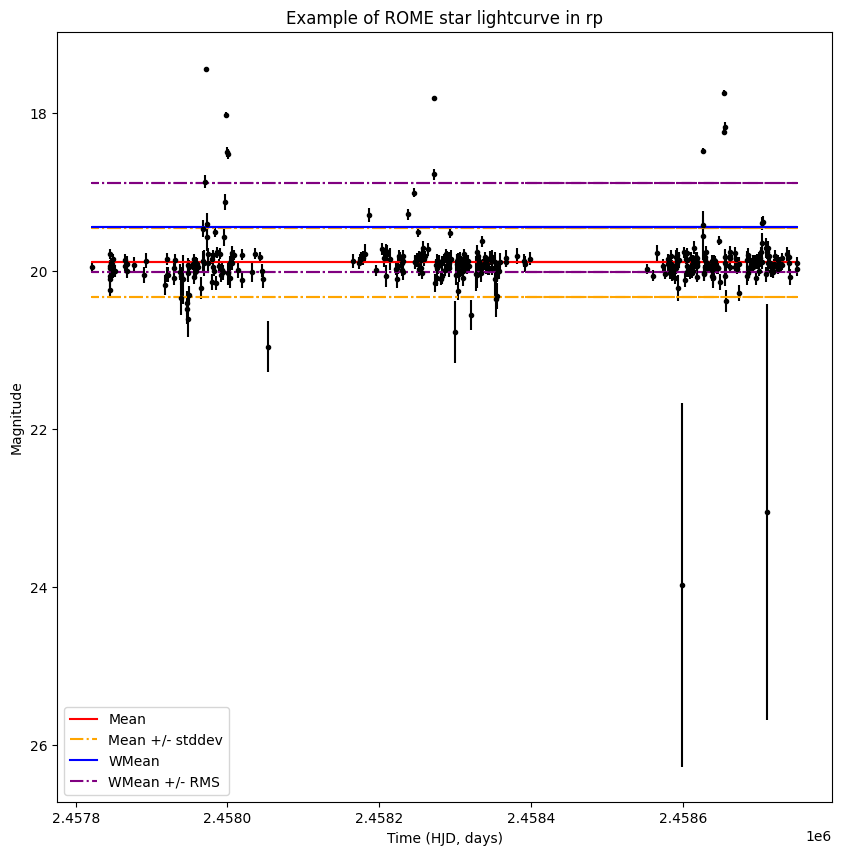

In [18]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

ax.errorbar(star_lc[valid,0], star_lc[valid,1], yerr=star_lc[valid,2], c='black', marker='.', ls='none')

ax.plot(star_lc[valid,0], [mean]*len(star_lc[valid,0]), c='red', ls='-', label='Mean')
ax.plot(star_lc[valid,0], [mean-stddev]*len(star_lc[valid,0]), c='orange', ls='-.', label='Mean +/- stddev')
ax.plot(star_lc[valid,0], [mean+stddev]*len(star_lc[valid,0]), c='orange', ls='-.')

ax.plot(star_lc[valid,0], [wmean]*len(star_lc[valid,0]), c='blue', ls='-', label='WMean')
ax.plot(star_lc[valid,0], [wmean-rms]*len(star_lc[valid,0]), c='purple', ls='-.', label='WMean +/- RMS')
ax.plot(star_lc[valid,0], [wmean+rms]*len(star_lc[valid,0]), c='purple', ls='-.')

ax.set_xlabel('Time (HJD, days)')
ax.set_ylabel('Magnitude')
[ymin, ymax] = ax.get_ylim() 
ax.set_ylim([ymax, ymin])
ax.legend()
ax.set_title('Example of ROME star lightcurve in ' + use_filter)

The RMS for this lightcurve is actually larger than the standard deviation, and the weighted mean is quite different from the mean.  The is because the brighter points above the main collection of points in the lightcurve have small uncertainties.  This implies that these measurements are accurate, and this object is really getting brighter.  